In [1]:
# Chargement des bibliothèques nécessaires
import pandas as pd
import numpy as np
import pickle

# Visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Modèles
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Support des modèles
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, f1_score, auc,
                             ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score, roc_curve, 
                             precision_recall_curve)


### Importation des données et configuration  
Importation des données depuis un fichier csv et configuration des fonctionnalités/interactions identifiées dans le notebook d'exploration des données (EDA) pour leur utilisation dans la modélisation.


In [3]:
# Chargement des données depuis le fichier CSV
dataset_path = 'twitter_human_bots_dataset.csv'

# Lecture du fichier CSV avec pandas
raw_df = pd.read_csv(dataset_path)

# Vérification des données importées
raw_df.head()


,Unnamed: 0,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,profile_background_image_url,profile_image_url,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,0,2016-10-15 21:32:11,False,False,"Blame @xaiax, Inspired by @MakingInvisible, us...",4,1589,4,False,787405734442958848,en,unknown,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/7874121826...,best_in_dumbest,11041,False,7.870,1403,bot
1,1,2016-11-09 05:01:30,False,False,Photographing the American West since 1980. I ...,536,860,880,False,796216118331310080,en,Estados Unidos,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/8023296328...,CJRubinPhoto,252,False,0.183,1379,human
2,2,2017-06-17 05:34:27,False,False,Scruffy looking nerf herder and @twitch broadc...,3307,172,594,True,875949740503859204,en,"Los Angeles, CA",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1278890453...,SVGEGENT,1001,False,0.864,1159,human
3,3,2016-07-21 13:32:25,True,False,Wife.Godmother.Friend.Feline Fanatic! Assistan...,8433,517,633,True,756119643622735875,en,"Birmingham, AL",NaN,http://pbs.twimg.com/profile_images/1284884924...,TinkerVHELPK5,1324,False,0.889,1489,human
4,4,2012-01-15 16:32:35,False,False,Loan coach at @mancity & Aspiring DJ,88,753678,116,True,464781334,en,"England, United Kingdom",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9952566258...,JoleonLescott,4202,True,1.339,3138,human


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37438 entries, 0 to 37437
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    37438 non-null  int64  
 1   created_at                    37438 non-null  object 
 2   default_profile               37438 non-null  bool   
 3   default_profile_image         37438 non-null  bool   
 4   description                   30181 non-null  object 
 5   favourites_count              37438 non-null  int64  
 6   followers_count               37438 non-null  int64  
 7   friends_count                 37438 non-null  int64  
 8   geo_enabled                   37438 non-null  bool   
 9   id                            37438 non-null  int64  
 10  lang                          29481 non-null  object 
 11  location                      37434 non-null  object 
 12  profile_background_image_url  32939 non-null  object 
 13  p

In [5]:
# Suppression de la colonne "index" si elle existe
if 'index' in raw_df.columns:
    raw_df.drop(columns=['index'], inplace=True)

# Création de la colonne 'bot' pour la classification binaire
if 'account_type' in raw_df.columns:
    raw_df['bot'] = raw_df['account_type'].apply(lambda x: 1 if x == 'bot' else 0)

# Conversion des colonnes booléennes en valeurs entières (0 ou 1)
bool_columns = ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']
for col in bool_columns:
    if col in raw_df.columns:
        raw_df[col] = raw_df[col].astype(int)

# Conversion de la colonne 'created_at' en format datetime
if 'created_at' in raw_df.columns:
    raw_df['created_at'] = pd.to_datetime(raw_df['created_at'])
    # Extraction de l'heure de création (format 24h)
    raw_df['hour_created'] = raw_df['created_at'].dt.hour

# Aperçu des modifications
raw_df.head()


,Unnamed: 0,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,...,profile_background_image_url,profile_image_url,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,account_type,bot,hour_created
0,0,2016-10-15 21:32:11,0,0,"Blame @xaiax, Inspired by @MakingInvisible, us...",4,1589,4,0,787405734442958848,...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/7874121826...,best_in_dumbest,11041,0,7.870,1403,bot,1,21
1,1,2016-11-09 05:01:30,0,0,Photographing the American West since 1980. I ...,536,860,880,0,796216118331310080,...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/8023296328...,CJRubinPhoto,252,0,0.183,1379,human,0,5
2,2,2017-06-17 05:34:27,0,0,Scruffy looking nerf herder and @twitch broadc...,3307,172,594,1,875949740503859204,...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1278890453...,SVGEGENT,1001,0,0.864,1159,human,0,5
3,3,2016-07-21 13:32:25,1,0,Wife.Godmother.Friend.Feline Fanatic! Assistan...,8433,517,633,1,756119643622735875,...,NaN,http://pbs.twimg.com/profile_images/1284884924...,TinkerVHELPK5,1324,0,0.889,1489,human,0,13
4,4,2012-01-15 16:32:35,0,0,Loan coach at @mancity & Aspiring DJ,88,753678,116,1,464781334,...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9952566258...,JoleonLescott,4202,1,1.339,3138,human,0,16


In [6]:
# Vérification et sélection des colonnes disponibles dans le dataset
columns_to_include = [
    'bot', 'screen_name', 'created_at', 'hour_created', 'verified', 'acct_location', 
    'geo_enabled', 'lang', 'default_profile', 'default_profile_image', 'favourites_count', 
    'followers_count', 'friends_count', 'statuses_count', 'average_tweets_per_day', 'account_age_days'
]

# Conserver uniquement les colonnes existantes dans raw_df
usable_columns = [col for col in columns_to_include if col in raw_df.columns]

# Création du DataFrame utilisable
df = raw_df[usable_columns]


In [7]:
# Supprimer raw_df pour libérer de la mémoire
del raw_df

In [8]:
# Création de nouvelles colonnes pour des fonctionnalités intéressantes
df['avg_daily_followers'] = np.round((df['followers_count'] / df['account_age_days']), 3)
df['avg_daily_friends'] = np.round((df['friends_count'] / df['account_age_days']), 3)
df['avg_daily_favorites'] = np.round((df['favourites_count'] / df['account_age_days']), 3)

# Transformations logarithmiques pour les données très asymétriques
df['friends_log'] = np.round(np.log(1 + df['friends_count']), 3)
df['followers_log'] = np.round(np.log(1 + df['followers_count']), 3)
df['favs_log'] = np.round(np.log(1 + df['favourites_count']), 3)
df['avg_daily_tweets_log'] = np.round(np.log(1 + df['average_tweets_per_day']), 3)

# Création de fonctionnalités interactives possibles
df['network'] = np.round(df['friends_log'] * df['followers_log'], 3)
df['tweet_to_followers'] = np.round(np.log(1 + df['statuses_count']) * np.log(1 + df['followers_count']), 3)

# Taux d'acquisition journalier (transformés logarithmiquement) pour les visualisations
df['follower_acq_rate'] = np.round(np.log(1 + (df['followers_count'] / df['account_age_days'])), 3)
df['friends_acq_rate'] = np.round(np.log(1 + (df['friends_count'] / df['account_age_days'])), 3)
df['favs_rate'] = np.round(np.log(1 + (df['favourites_count'] / df['account_age_days'])), 3)


In [9]:
df.head()

,bot,screen_name,created_at,hour_created,verified,geo_enabled,lang,default_profile,default_profile_image,favourites_count,...,avg_daily_favorites,friends_log,followers_log,favs_log,avg_daily_tweets_log,network,tweet_to_followers,follower_acq_rate,friends_acq_rate,favs_rate
0,1,best_in_dumbest,2016-10-15 21:32:11,21,0,0,en,0,0,4,...,0.003,1.609,7.371,1.609,2.183,11.860,68.625,0.757,0.003,0.003
1,0,CJRubinPhoto,2016-11-09 05:01:30,5,0,0,en,0,0,536,...,0.389,6.781,6.758,6.286,0.168,45.826,37.395,0.485,0.494,0.328
2,0,SVGEGENT,2017-06-17 05:34:27,5,0,1,en,0,0,3307,...,2.853,6.389,5.153,8.104,0.623,32.923,35.608,0.138,0.414,1.349
3,0,TinkerVHELPK5,2016-07-21 13:32:25,13,0,1,en,1,0,8433,...,5.664,6.452,6.250,9.040,0.636,40.325,44.932,0.298,0.354,1.897
4,0,JoleonLescott,2012-01-15 16:32:35,16,1,1,en,0,0,88,...,0.028,4.762,13.533,4.489,0.850,64.444,112.911,5.486,0.036,0.028


#### Première sélection des fonctionnalités 
Ces fonctionnalités doivent être accessibles par tous les types de modèles.


In [10]:
# Liste des fonctionnalités à utiliser pour le modèle
features = [
    'verified', 
    # 'created_at', 
    # 'hour_created', 
    # 'lang', 
    # 'acct_location',
    'geo_enabled', 
    'default_profile', 
    'default_profile_image', 
    'favourites_count', 
    'followers_count', 
    'friends_count', 
    'statuses_count', 
    'average_tweets_per_day',
    # 'avg_daily_followers', 
    # 'avg_daily_friends',
    # 'avg_daily_favorites',
    'network', 
    'tweet_to_followers', 
    'follower_acq_rate', 
    'friends_acq_rate', 
    'favs_rate'
]

# Sélection des variables explicatives et de la variable cible
X = df[features]
y = df['bot']


In [11]:
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)


## Évaluation de base des modèles
Les modèles à évaluer :

- KNearestNeighbors
- LogisticRegression
- NaiveBayes (Gaussian, Bernoulli, Multinomial)
- DecisionTree
- RandomForest
- XGBoost


In [12]:
# Importation de KFold
from sklearn.model_selection import KFold

def multi_model_eval(models, X, y, cv):
    for model in models:
        # Calcul des scores de validation croisée pour chaque métrique
        accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        precision = cross_val_score(model, X, y, cv=cv, scoring='precision')
        recall = cross_val_score(model, X, y, cv=cv, scoring='recall')
        f1 = cross_val_score(model, X, y, cv=cv, scoring='f1')
        roc_auc = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')

        print(f"Model: {model.__class__.__name__}")
        print(f"Accuracy: {np.mean(accuracy):.5f} +- {np.std(accuracy):.5f}")
        print(f"Precision: {np.mean(precision):.5f} +- {np.std(precision):.5f}")
        print(f"Recall: {np.mean(recall):.5f} +- {np.std(recall):.5f}")
        print(f"F1 Score: {np.mean(f1):.5f} +- {np.std(f1):.5f}")
        print(f"ROC AUC: {np.mean(roc_auc):.5f} +- {np.std(roc_auc):.5f}\n")

# Définir les modèles
knn = KNeighborsClassifier(n_neighbors=10)
lr = LogisticRegression()

# Mise à l'échelle des données
scalar = StandardScaler()
scalar.fit(X)
X_train_scaled = scalar.transform(X)

# Liste des modèles à évaluer
model_list = [knn, lr]

# Validation croisée
kf = KFold(n_splits=5, shuffle=True, random_state=33)

# Évaluation des modèles
multi_model_eval(model_list, X_train_scaled, y, kf)


Model: KNeighborsClassifier
Accuracy: 0.84764 +- 0.00355
Precision: 0.81887 +- 0.00126
Recall: 0.69461 +- 0.01086
F1 Score: 0.75159 +- 0.00607
ROC AUC: 0.89970 +- 0.00290

Model: LogisticRegression
Accuracy: 0.80838 +- 0.00322
Precision: 0.71382 +- 0.00316
Recall: 0.70548 +- 0.00930
F1 Score: 0.70959 +- 0.00470
ROC AUC: 0.85832 +- 0.00228



In [13]:
# Modèles qui ne nécessitent pas de mise à l'échelle
gnb = GaussianNB()
bnb = BernoulliNB()
mnb = MultinomialNB()
tree = DecisionTreeClassifier()
forest = RandomForestClassifier()
xgb = XGBClassifier()

# Liste des modèles à évaluer
model_list = [gnb, bnb, mnb, tree, forest, xgb]

# Validation croisée
kf = KFold(n_splits=3, shuffle=True, random_state=33)

# Évaluation des modèles
multi_model_eval(model_list, X, y, kf)


Model: GaussianNB
Accuracy: 0.64998 +- 0.02125
Precision: 0.46392 +- 0.03035
Recall: 0.63383 +- 0.41137
F1 Score: 0.45312 +- 0.25488
ROC AUC: 0.82077 +- 0.00462

Model: BernoulliNB
Accuracy: 0.74505 +- 0.00162
Precision: 0.69522 +- 0.00737
Recall: 0.41250 +- 0.00776
F1 Score: 0.51777 +- 0.00814
ROC AUC: 0.80141 +- 0.00060

Model: MultinomialNB
Accuracy: 0.46824 +- 0.00288
Precision: 0.38261 +- 0.00190
Recall: 0.98149 +- 0.00068
F1 Score: 0.55059 +- 0.00200
ROC AUC: 0.59509 +- 0.00291

Model: DecisionTreeClassifier
Accuracy: 0.81842 +- 0.00245
Precision: 0.72249 +- 0.00334
Recall: 0.73867 +- 0.00260
F1 Score: 0.73172 +- 0.00398
ROC AUC: 0.79738 +- 0.00165

Model: RandomForestClassifier
Accuracy: 0.87534 +- 0.00086
Precision: 0.85696 +- 0.00296
Recall: 0.75116 +- 0.00302
F1 Score: 0.80052 +- 0.00162
ROC AUC: 0.92879 +- 0.00155

Model: XGBClassifier
Accuracy: 0.87414 +- 0.00049
Precision: 0.84672 +- 0.00303
Recall: 0.75800 +- 0.00256
F1 Score: 0.79990 +- 0.00046
ROC AUC: 0.92986 +- 0.0014

In [14]:
def roc_curve_cv(model, X, y, kf, model_alias='Model'):
    """
    Tracer la courbe ROC pour chaque pli de validation croisée et la courbe ROC moyenne.
    
    :param model: Le modèle à évaluer (ex. RandomForestClassifier)
    :param X: Les caractéristiques des données
    :param y: La variable cible (étiquettes)
    :param kf: KFold pour la validation croisée
    :param model_alias: Nom du modèle pour l'affichage
    """
    tpr_list = []  # True positive rate (sensibilité)
    fpr_list = []  # False positive rate (1 - spécificité)
    auc_list = []   # AUC pour chaque pli
    
    plt.figure(figsize=(8, 6))
    
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        y_probs = model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive
        
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        roc_auc = auc(fpr, tpr)
        
        # Ajouter à la liste pour la courbe ROC moyenne
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        auc_list.append(roc_auc)
        
        # Tracer la courbe ROC pour chaque pli
        plt.plot(fpr, tpr, lw=1, alpha=0.7, label=f'Fold {fold+1} (AUC = {roc_auc:.4f})')
    
    # Calculer la moyenne des courbes ROC
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)
    
    for fpr, tpr in zip(fpr_list, tpr_list):
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
    
    mean_tpr /= len(fpr_list)
    mean_auc = np.mean(auc_list)
    
    # Tracer la courbe ROC moyenne
    plt.plot(mean_fpr, mean_tpr, color='y', label=f'Mean ROC curve (AUC = {mean_auc:.2f})', lw=2)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonale (auc = 0.5)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {model_alias}')
    plt.legend(loc='lower right')
    plt.show()


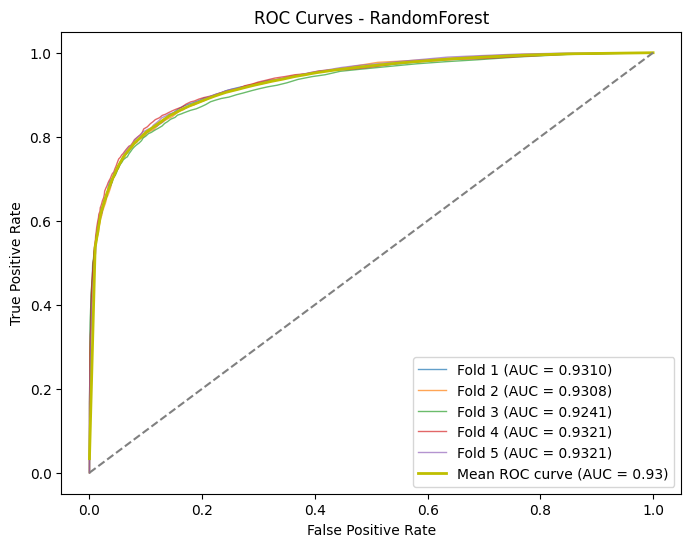

In [15]:
# RandomForest
forest = RandomForestClassifier()
kf = KFold(n_splits=5, shuffle=True, random_state=33)

roc_curve_cv(forest, X, y, kf, model_alias='RandomForest')

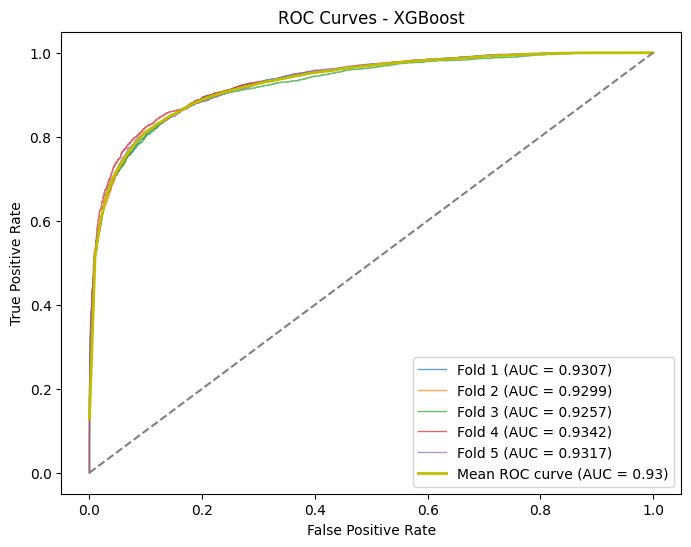

In [16]:
# Définir le modèle XGBoost
xgb = XGBClassifier()

# Définir la validation croisée avec KFold
kf = KFold(n_splits=5, shuffle=True, random_state=33)

# Appliquer la fonction de tracé de la courbe ROC pour XGBoost
roc_curve_cv(xgb, X, y, kf, model_alias='XGBoost')


### Équilibrage des poids des classes

In [17]:
# Calcul du nombre de bots et d'humains dans le dataset
num_bots = len(df[df['bot'] == 1])
num_humans = len(df[df['bot'] == 0])

# Affichage des résultats
print("Nombre de bots : ", num_bots)
print("Nombre d'humains : ", num_humans)
print(f'Pourcentage de bots sur le total : {(num_bots / len(df)) * 100:.2f}%')


Nombre de bots :  12425
Nombre d'humains :  25013
Pourcentage de bots sur le total : 33.19%


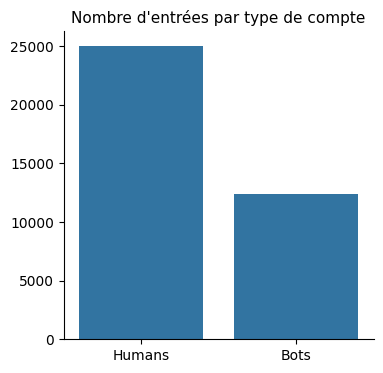

In [18]:
# Types d'entrées et leur nombre
types = ['Humans', 'Bots']
counts = [num_humans, num_bots]

# Tracer le graphique en barres
plt.figure(figsize=(4, 4))
sns.barplot(x=types, y=counts)
plt.title("Nombre d'entrées par type de compte", fontsize=11)
sns.despine()
plt.show()


In [19]:
# Estimation du ratio humains / bots pour XGBoost
estimate = num_humans / num_bots
estimate


2.013118712273642

In [20]:
# Modèles avec ajustement des poids de classe
forest = RandomForestClassifier(class_weight='balanced')  
xgb = XGBClassifier(scale_pos_weight=estimate) 

# Liste des modèles et validation croisée
models = [forest, xgb]
kf = KFold(n_splits=5, shuffle=True, random_state=33)


In [21]:
# Évaluation des modèles
multi_model_eval(models, X, y, kf)

Model: RandomForestClassifier
Accuracy: 0.87673 +- 0.00229
Precision: 0.86082 +- 0.00411
Recall: 0.74993 +- 0.00799
F1 Score: 0.80187 +- 0.00505
ROC AUC: 0.93002 +- 0.00245

Model: XGBClassifier
Accuracy: 0.86690 +- 0.00170
Precision: 0.78970 +- 0.00372
Recall: 0.81641 +- 0.00528
F1 Score: 0.80281 +- 0.00129
ROC AUC: 0.92989 +- 0.00223



### Courbes de ROC avec validation croisée

#### RandomForest

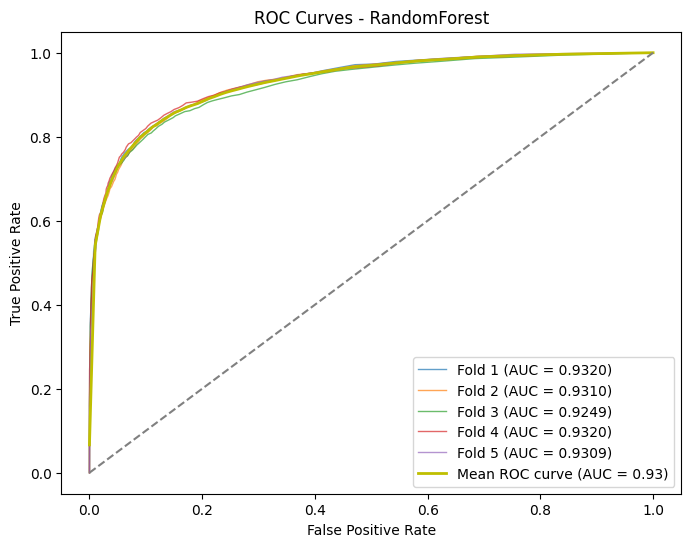

In [22]:
# Tracer la courbe ROC pour le modèle RandomForest avec validation croisée
roc_curve_cv(forest, X, y, kf, model_alias='RandomForest')


#### XGBoost

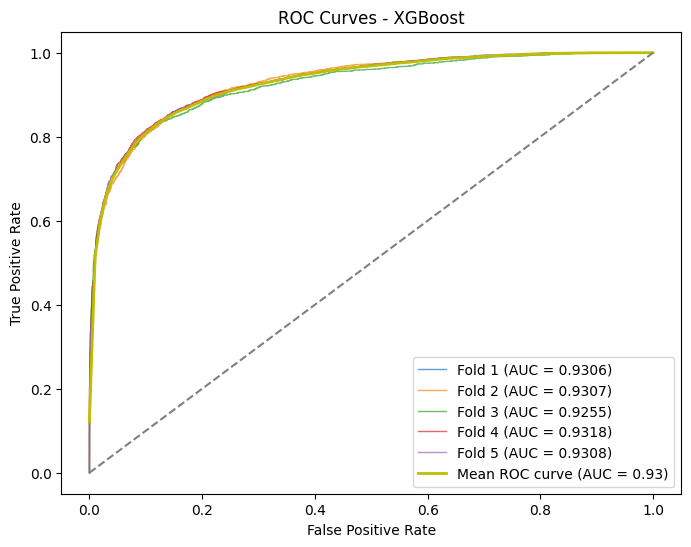

In [23]:
# Tracer la courbe ROC pour le modèle XGBoost
roc_curve_cv(xgb, X, y, kf, model_alias='XGBoost')

### Matrices de confusion

#### Examinons les matrices de confusion de chaque modèle pour une seule répartition train/test.

In [24]:
# Diviser les données en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=3333)


#### RandomForest

In [25]:
# Entraînement du modèle RandomForest avec équilibrage des classes
forest = RandomForestClassifier(class_weight='balanced')

# Entraînement du modèle
forest.fit(X_train, y_train)

# Prédictions sur l'ensemble de validation
preds = forest.predict(X_val)

In [26]:
def metrics_report(predictions, true_values):
    accuracy = accuracy_score(true_values, predictions)
    precision = precision_score(true_values, predictions)
    recall = recall_score(true_values, predictions)
    f1 = f1_score(true_values, predictions)
    roc_auc = roc_auc_score(true_values, predictions)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    
# Utilisation de cette fonction après les prédictions
metrics_report(preds, y_val)

Accuracy: 0.8769
Precision: 0.8621
Recall: 0.7466
F1 Score: 0.8002
ROC AUC: 0.8439


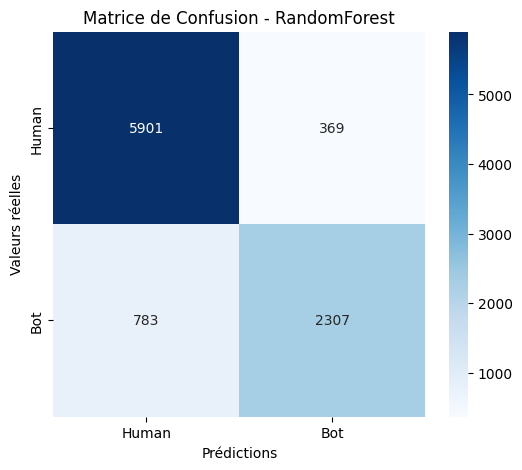

In [27]:
# Calcul de la matrice de confusion
cm = confusion_matrix(y_val, preds)

# Création d'une figure et tracé de la matrice de confusion
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'Bot'], yticklabels=['Human', 'Bot'])
plt.title('Matrice de Confusion - RandomForest')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.show()

#### XGBoost

In [28]:
# Entraînement du modèle XGBoost
xgb = XGBClassifier(scale_pos_weight=estimate)
xgb.fit(X_train, y_train)

# Prédictions sur les données de validation
preds = xgb.predict(X_val)

# Affichage du rapport de classification
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      6270
           1       0.78      0.82      0.80      3090

    accuracy                           0.87      9360
   macro avg       0.85      0.85      0.85      9360
weighted avg       0.87      0.87      0.87      9360



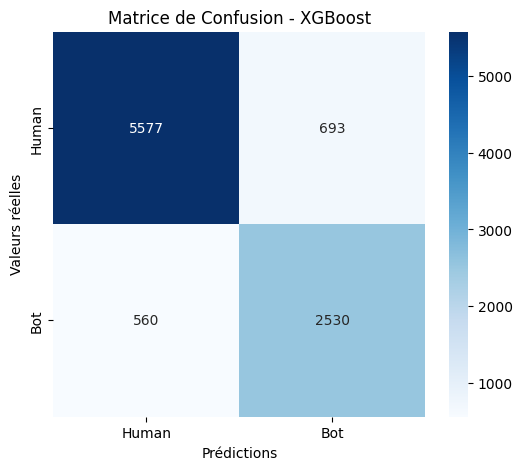

In [29]:
# Calcul de la matrice de confusion
cm = confusion_matrix(y_val, preds)

# Création d'une figure et tracé de la matrice de confusion
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'Bot'], yticklabels=['Human', 'Bot'])
plt.title('Matrice de Confusion - XGBoost')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.show()

### Importance des caractéristiques

#### Comment chaque modèle utilise-t-il les caractéristiques ?

In [30]:
def plot_feature_importance(model, features, model_alias='Model'):
    # Récupérer l'importance des caractéristiques
    importance = model.feature_importances_
    
    # Créer un DataFrame avec les caractéristiques et leurs importances
    feature_importance = pd.DataFrame({'feature': features, 'importance': importance})
    
    # Trier les caractéristiques par importance décroissante
    feature_importance = feature_importance.sort_values(by='importance', ascending=False)
    
    # Tracer le graphique
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title(f'Feature Importance for {model_alias}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

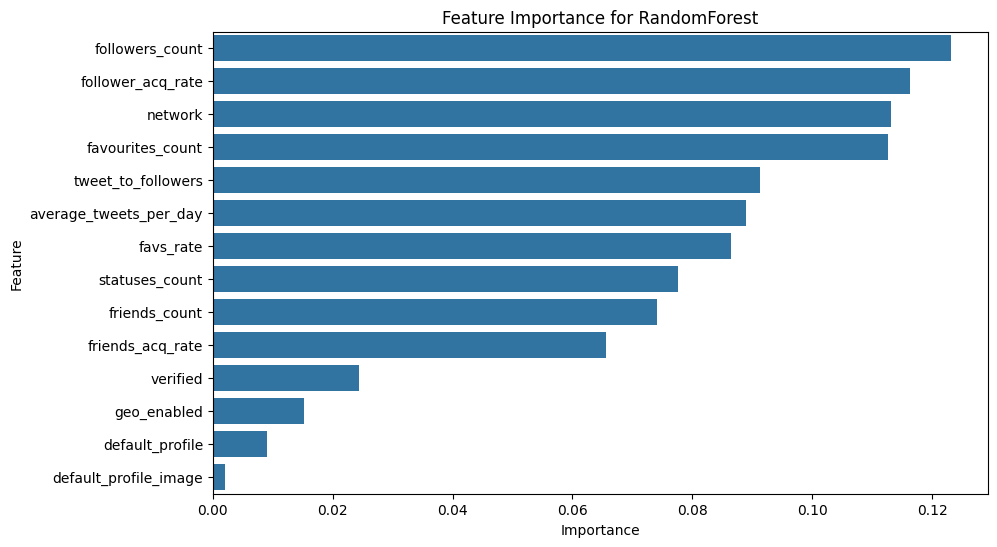

In [31]:
# Tracer l'importance des caractéristiques
plot_feature_importance(forest, features, model_alias='RandomForest')

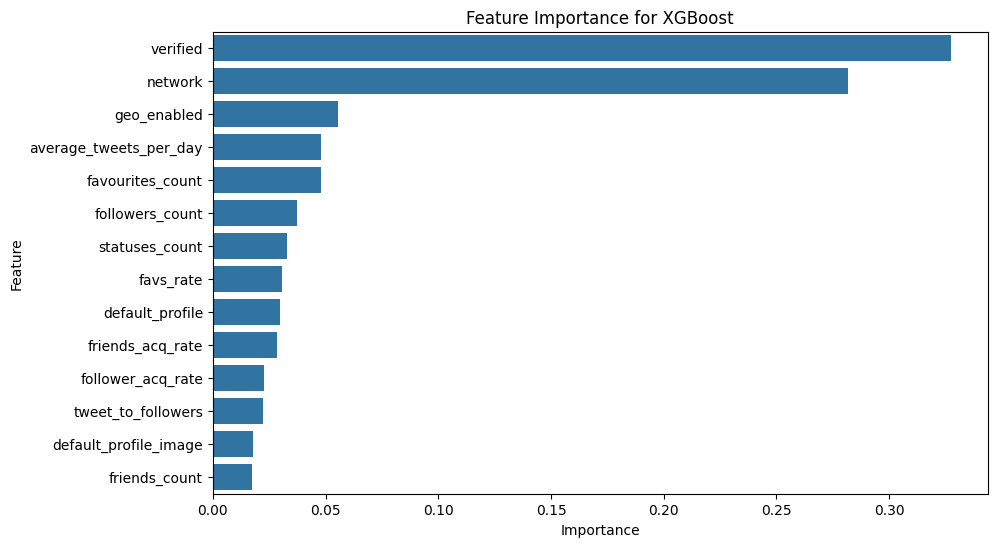

In [32]:
# Tracer l'importance des caractéristiques
plot_feature_importance(xgb, features, model_alias='XGBoost')

#### Optimisation continue et sélection des caractéristiques

In [33]:
df.head()

,bot,screen_name,created_at,hour_created,verified,geo_enabled,lang,default_profile,default_profile_image,favourites_count,...,avg_daily_favorites,friends_log,followers_log,favs_log,avg_daily_tweets_log,network,tweet_to_followers,follower_acq_rate,friends_acq_rate,favs_rate
0,1,best_in_dumbest,2016-10-15 21:32:11,21,0,0,en,0,0,4,...,0.003,1.609,7.371,1.609,2.183,11.860,68.625,0.757,0.003,0.003
1,0,CJRubinPhoto,2016-11-09 05:01:30,5,0,0,en,0,0,536,...,0.389,6.781,6.758,6.286,0.168,45.826,37.395,0.485,0.494,0.328
2,0,SVGEGENT,2017-06-17 05:34:27,5,0,1,en,0,0,3307,...,2.853,6.389,5.153,8.104,0.623,32.923,35.608,0.138,0.414,1.349
3,0,TinkerVHELPK5,2016-07-21 13:32:25,13,0,1,en,1,0,8433,...,5.664,6.452,6.250,9.040,0.636,40.325,44.932,0.298,0.354,1.897
4,0,JoleonLescott,2012-01-15 16:32:35,16,1,1,en,0,0,88,...,0.028,4.762,13.533,4.489,0.850,64.444,112.911,5.486,0.036,0.028


In [34]:
features = ['verified', 
            #'created_at',
            'hour_created',
            #'lang',
            #'acct_location',
            'geo_enabled', 
            'default_profile', 
            'default_profile_image', 
            'favourites_count', 
            'followers_count', 
            'friends_count', 
            'statuses_count', 
            'average_tweets_per_day',
            #'avg_daily_followers', 
            #'avg_daily_friends',
            #'avg_daily_favorites',
            'network', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate', 
            #'favs_rate'
           ]

X = df[features]
y = df['bot']

X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=1234)

### Trouver le meilleur modèle XGBoost

In [35]:
xgb = XGBClassifier(scale_pos_weight=1.8, 
                    tree_method='hist', 
                    learning_rate=0.1,           
                    eta=0.01,                 
                    max_depth=7,                
                    gamma=0.05,
                    n_estimators=200,
                    colsample_bytree=.8
                   )

model_list = [xgb]

In [36]:
kf = KFold(n_splits=5, shuffle=True, random_state=33)

multi_model_eval(model_list, X, y, kf)

Model: XGBClassifier
Accuracy: 0.86846 +- 0.00547
Precision: 0.80394 +- 0.01269
Recall: 0.80391 +- 0.01161
F1 Score: 0.80382 +- 0.00807
ROC AUC: 0.93125 +- 0.00419



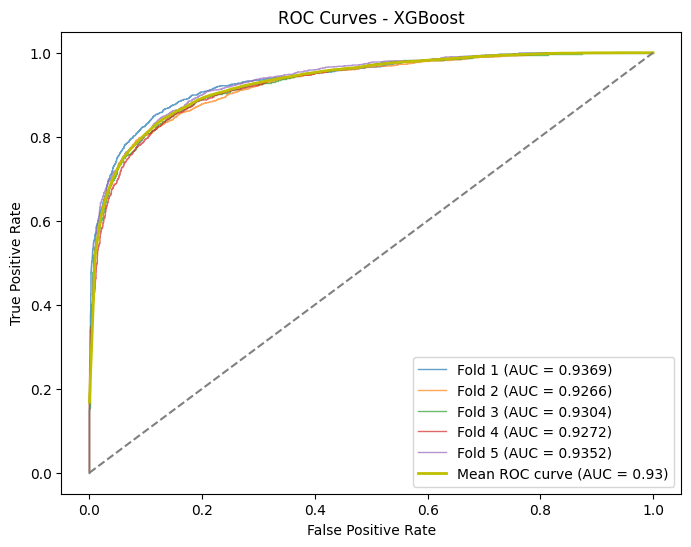

In [37]:
roc_curve_cv(xgb, X, y, kf, model_alias='XGBoost')

####  Essayons tout de même d'assembler RandomForest avec XGBoost.

In [38]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.3, random_state=1234)

In [39]:
forest = RandomForestClassifier(class_weight='balanced')
forest = forest.fit(X_train, y_train)

xgb = XGBClassifier(scale_pos_weight=1.8, 
                    tree_method='hist', 
                    learning_rate=0.1,           
                    eta=0.01,                 
                    max_depth=7,                
                    gamma=0.05,
                    n_estimators=200,
                    colsample_bytree=.8
                   )

xgb = xgb.fit(X_train, y_train)

In [40]:
models = [('forest', forest), ('xgb', xgb)]

voting_classifier = VotingClassifier(estimators=models,
                                     voting='soft',
                                     n_jobs=-1)

voting_classifier = voting_classifier.fit(X_train, y_train)

In [41]:
voting_classifier_prediction = voting_classifier.predict(X_val)

metrics_report(voting_classifier_prediction, y_val)

Accuracy: 0.8713
Precision: 0.8299
Recall: 0.7751
F1 Score: 0.8016
ROC AUC: 0.8475


#### Meilleur modèle XGBoost : Formation complète, tests et résultats

In [42]:

best_model = XGBClassifier(scale_pos_weight=1.8, 
                    tree_method='hist', 
                    learning_rate=0.1,           
                    eta=0.01,                 
                    max_depth=7,                
                    gamma=0.05,
                    n_estimators=200,
                    colsample_bytree=.8
                   )

In [43]:
best_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric=None,
              feature_types=None, gamma=0.05, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [44]:
best_model_prediction = best_model.predict(X_test)

metrics_report(best_model_prediction, y_test)

Accuracy: 0.8716
Precision: 0.8004
Recall: 0.8043
F1 Score: 0.8024
ROC AUC: 0.8541


In [45]:
# Affichage du rapport de classification
print(classification_report(best_model_prediction, y_test))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      7575
           1       0.80      0.80      0.80      3657

    accuracy                           0.87     11232
   macro avg       0.85      0.85      0.85     11232
weighted avg       0.87      0.87      0.87     11232



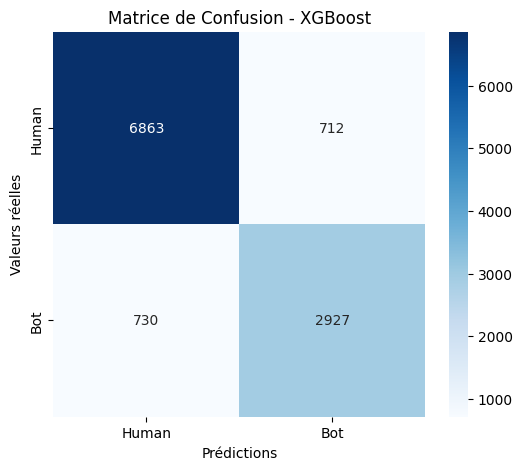

In [46]:
# Calcul de la matrice de confusion
cm = confusion_matrix(best_model_prediction, y_test)

# Création d'une figure et tracé de la matrice de confusion
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'Bot'], yticklabels=['Human', 'Bot'])
plt.title('Matrice de Confusion - XGBoost')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.show()

ROC AUC score: 0.9306



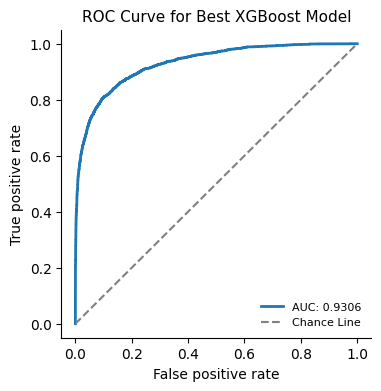

In [47]:
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])

model_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])

plt.figure(figsize=(4, 4), dpi=100)
plt.plot(fpr, tpr,lw=2, label=f'AUC: {model_auc:.4f}')
plt.plot([0,1],[0,1],c='grey',ls='--', label='Chance Line')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate', fontsize=10)
plt.ylabel('True positive rate', fontsize=10)
plt.title('ROC Curve for Best XGBoost Model', fontsize=11)
plt.legend(loc='lower right', prop={'size': 8}, frameon=False)
sns.despine()
print(f'ROC AUC score: {model_auc:.4f}')
print("")
plt.show();

Precision score: 0.8004
Rcall score: 0.8043



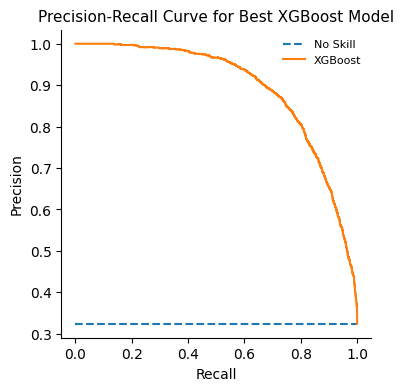

In [48]:
# Prec Recal Curve here

model_precision, model_recall, _ = precision_recall_curve(y_test, best_model.predict_proba(X_test)[:,1])

# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)

plt.figure(figsize=(4, 4), dpi=100)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(model_recall, model_precision, marker=',', label='XGBoost')
# axis labels
plt.title('Precision-Recall Curve for Best XGBoost Model', fontsize=11)
plt.xlabel('Recall', fontsize=10)
plt.ylabel('Precision', fontsize=10)
# show the legend
plt.legend(loc='upper right', prop={'size': 8}, frameon=False)
# show the plot
sns.despine()

pred = best_model.predict(X_test)
prec_score = precision_score(y_test, pred)
rec_score = recall_score(y_test, pred)

print(f'Precision score: {prec_score:.4f}')
print(f'Rcall score: {rec_score:.4f}')
print("")

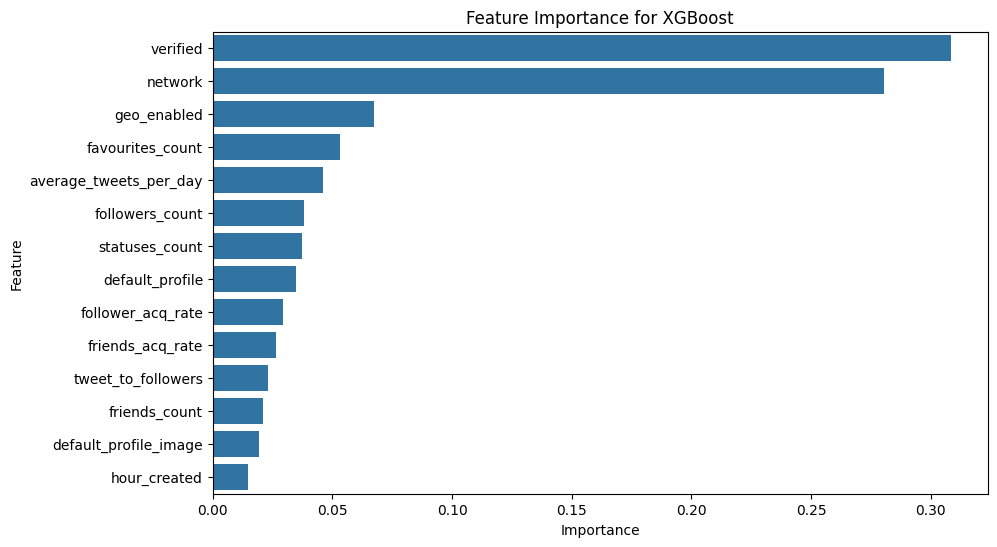

In [49]:
plot_feature_importance(best_model, features, model_alias='XGBoost')

### Entraînement du modèle sur l'ensemble des données à utiliser pour les nouvelles prédictions

In [50]:
features = ['verified', 
            'hour_created',
            'geo_enabled', 
            'default_profile', 
            'default_profile_image', 
            'favourites_count', 
            'followers_count', 
            'friends_count', 
            'statuses_count', 
            'average_tweets_per_day',
            'network', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate', 
           ]

X = df[features]
y = df['bot']

In [51]:
fully_trained_model = XGBClassifier(scale_pos_weight=1.8, 
                                    tree_method='hist', 
                                    learning_rate=0.1,           
                                    eta=0.01,                 
                                    max_depth=7,                
                                    gamma=0.05,
                                    n_estimators=200,
                                    colsample_bytree=.8
                                   )

fully_trained_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric=None,
              feature_types=None, gamma=0.05, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [52]:
# Sauvegarder le modèle en tant que fichier pickle
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(fully_trained_model, file)

print("Modèle sauvegardé dans le fichier 'xgb_model.pkl'")

Modèle sauvegardé dans le fichier 'xgb_model.pkl'


In [53]:
import pickle
import pandas as pd
import numpy as np

# Function to preprocess the tweet (replace this with your actual preprocessing pipeline)
def preprocess_tweet(tweet):
    # This should be the same as your training preprocessing steps, e.g., text vectorization, etc.
    # For now, I'll assume it's a placeholder. You'll need to implement text preprocessing like tokenization, vectorization, etc.
    
    # Example: if using the same features as in your training:
    # You could convert text to relevant features like word counts, presence of keywords, etc.
    # You can also use TF-IDF, Word2Vec, etc.
    
    tweet_features = {
        'verified': 0,  # Bots often appear to be verified to gain more trust
        'hour_created': 12,  # Midday posts could suggest automated scheduling
        'geo_enabled': 0,  # Bots usually don't have geo-location enabled
        'default_profile': 0,  # Bots often don't customize their profiles
        'default_profile_image': 1,  # Bots might use the default image
        'favourites_count': 1000,  # High number of favorites from bot accounts
        'followers_count': 10000,  # Bots tend to have a large number of followers
        'friends_count': 0,  # Bots don't follow back
        'statuses_count': 500,  # Bots often post at high frequencies
        'average_tweets_per_day': 50,  # Bots tweet excessively
        'network': 1,  # Assuming the tweet is from a network associated with bot behavior
        'tweet_to_followers': 0.1,  # Low engagement rate, typical of bots
        'follower_acq_rate': 0.2,  # Bots often acquire followers at a steady but not too fast pace
        'friends_acq_rate': 0.0,  # Bots don't acquire friends
    }
    
    # Example logic: If the tweet is from a bot-like user
    if 'follow' in tweet.lower() or 'bot' in tweet.lower():
        tweet_features['followers_count'] = 10000
        tweet_features['statuses_count'] = 500
        tweet_features['average_tweets_per_day'] = 50
        tweet_features['friends_acq_rate'] = 0.0

    return pd.DataFrame([tweet_features])

# Load the trained model from the pickle file
with open('xgb_model.pkl', 'rb') as file:
    model = pickle.load(file)

# Example: input tweet (robotic)
input_tweet = "Just followed 100 accounts! #verified #automation #bot #followback"

# Preprocess the tweet
preprocessed_tweet = preprocess_tweet(input_tweet)

# Make the prediction
prediction = model.predict(preprocessed_tweet)

# Print the result
if prediction[0] == 1:
    print("The tweet is classified as a Bot.")
else:
    print("The tweet is classified as a Human.")


The tweet is classified as a Bot.


In [57]:
import pickle
import pandas as pd

# Function to classify based on provided tweet features
def classify_tweet(tweet_features):
    # Convert the tweet features into a pandas DataFrame (the format the model expects)
    tweet_df = pd.DataFrame([tweet_features])

    # Load the trained model from the pickle file
    with open('xgb_model.pkl', 'rb') as file:
        model = pickle.load(file)

    # Make the prediction
    prediction = model.predict(tweet_df)

    # Output the classification result
    if prediction[0] == 1:
        return "The tweet is classified as a Bot."
    else:
        return "The tweet is classified as a Human."

# Example of tweet features provided by the user
tweet_features = {
    'verified': 0,
    'hour_created': 12,
    'geo_enabled': 0,
    'default_profile': 0,
    'default_profile_image': 1,
    'favourites_count': 1000,
    'followers_count': 10000,
    'friends_count': 0,
    'statuses_count': 500,
    'average_tweets_per_day': 50,
    'network': 1,
    'tweet_to_followers': 0.1,
    'follower_acq_rate': 0.2,
    'friends_acq_rate': 0.0
}

# Call the function with tweet features
result = classify_tweet(tweet_features)
print(result)


The tweet is classified as a Bot.


In [61]:
import pandas as pd
from flask import Flask, request, jsonify
from flask_cors import CORS  # Import Flask-CORS

app = Flask(__name__)
CORS(app)  # Enable CORS for all routes by default

@app.route('/predict_bot', methods=['POST'])
def predict_bot():
    try:
        # Parse JSON payload
        data = request.json.get('tweet_features', {})
        
        # Convert to DataFrame
        df = pd.DataFrame([data])
        
        # Convert columns to the appropriate data types
        for col in df.columns:
            if col in ['tweet_to_followers', 'follower_acq_rate', 'friends_acq_rate']:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            else:
                df[col] = pd.to_numeric(df[col], errors='coerce', downcast='integer')

        # Check for NaN values (optional, depending on your model's expectations)
        df.fillna(0, inplace=True)
        
        # Example prediction (replace with your model prediction)
        prediction = model.predict(df)
        response = {"classification": "Bot" if prediction[0] == 1 else "Not Bot"}
        return jsonify(response)
    except Exception as e:
        print(f"Error occurred: {e}")
        return jsonify({"error": str(e)}), 500

if __name__ == '__main__':
    app.run(port=5001)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5001
Press CTRL+C to quit
127.0.0.1 - - [25/Dec/2024 13:59:03] "OPTIONS /predict_bot HTTP/1.1" 200 -
127.0.0.1 - - [25/Dec/2024 13:59:03] "POST /predict_bot HTTP/1.1" 200 -
127.0.0.1 - - [25/Dec/2024 13:59:16] "OPTIONS /predict_bot HTTP/1.1" 200 -
127.0.0.1 - - [25/Dec/2024 13:59:17] "POST /predict_bot HTTP/1.1" 200 -
